In [1]:
import pandas as pd
from lifelines import KaplanMeierFitter, NelsonAalenFitter, CoxPHFitter
from lifelines.plotting import plot_lifetimes
import matplotlib.pyplot as plt


In [29]:
file_path = 'Rhabdomyosarcoma.xlsx'

data = pd.read_excel(file_path, sheet_name='Rhabdomyosarcoma', header=None)

new_header = data.iloc[1].copy()  
data.iloc[1, :6], data.iloc[0, :6] = data.iloc[0, :6], new_header[:6] 

new_header = data.iloc[1]
df = data[2:]  
df.columns = new_header  

df.replace("Blank(s)", pd.NA, inplace=True)

missing_values_percentage = df.isnull().mean() * 100
columns_to_drop = missing_values_percentage[missing_values_percentage > 10].index
df = df.drop(columns=columns_to_drop)
df = df.dropna()

df.columns = df.columns.str.strip().str.replace(' ', '_')



print(df.shape)



(80, 103)


/var/folders/yc/6_y2kwm52pl6rfhyt4mfj_q40000gn/T/ipykernel_7043/2381749144.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace("Blank(s)", pd.NA, inplace=True)


In [30]:
new_header 

0                               Year of death recode
1                                             censor
2                                    Survival months
3                Age recode with single ages and 90+
4                                      Ped vs Adults
                           ...                      
265                      Marital status at diagnosis
266                      CoC Accredited Flag (2018+)
267    Median household income inflation adj to 2021
268                       Rural-Urban Continuum Code
269            Race and origin (recommended by SEER)
Name: 1, Length: 270, dtype: object

In [37]:
df1

,censor,Survival_months,Year_of_diagnosis,Primary_Site,Histologic_Type_ICD-O-3,RX_Summ--Surg_Prim_Site_(1998+),Regional_nodes_examined_(1988+),Regional_nodes_positive_(1988+),Adjusted_CS_site-specific_factor_7_(2004-2017_varying_by_schema),Record_number_recode,...,"Median_household_income_inflation_adj_to_2021_$60,000 - $64,999","Median_household_income_inflation_adj_to_2021_$65,000 - $69,999","Median_household_income_inflation_adj_to_2021_$70,000 - $74,999","Median_household_income_inflation_adj_to_2021_$75,000+",Rural-Urban_Continuum_Code_Counties in metropolitan areas ge 1 million pop,"Rural-Urban_Continuum_Code_Counties in metropolitan areas of 250,000 to 1 million pop",Rural-Urban_Continuum_Code_Counties in metropolitan areas of lt 250 thousand pop,Rural-Urban_Continuum_Code_Nonmetropolitan counties adjacent to a metropolitan area,Rural-Urban_Continuum_Code_Nonmetropolitan counties not adjacent to a metropolitan area,Race_and_origin_(recommended_by_SEER)_All races/ethnicities
2,0,229,2001,712,9503,0,99,99,999,1,...,False,False,False,True,False,True,False,False,False,True
3,1,46,2008,712,9503,30,99,99,999,1,...,False,False,False,True,False,True,False,False,False,True
4,1,12,2017,495,9501,30,0,98,999,1,...,False,False,False,True,False,True,False,False,False,True
5,0,29,2017,711,9503,21,99,99,999,1,...,False,False,False,True,False,True,False,False,False,True
6,1,17,2018,718,9503,30,99,99,999,1,...,False,False,True,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1,10,2013,719,9501,30,99,99,999,1,...,False,False,False,False,False,True,False,False,False,True
78,0,70,2014,713,9503,30,99,99,999,1,...,False,False,False,False,False,True,False,False,False,True
79,0,66,2015,694,9501,41,99,99,999,1,...,False,False,False,False,False,False,True,False,False,True
80,0,36,2017,714,9503,0,99,99,999,1,...,False,False,False,False,False,True,False,False,False,True


In [21]:
df1 = df.copy()
cat_cols = df1.select_dtypes(include='object').columns.tolist()
df1 = pd.get_dummies(df1, columns=cat_cols)
df1

,censor,Survival_months,Year_of_diagnosis,Primary_Site,Histologic_Type_ICD-O-3,RX_Summ--Surg_Prim_Site_(1998+),Regional_nodes_examined_(1988+),Regional_nodes_positive_(1988+),Adjusted_CS_site-specific_factor_7_(2004-2017_varying_by_schema),Record_number_recode,...,"Median_household_income_inflation_adj_to_2021_$60,000 - $64,999","Median_household_income_inflation_adj_to_2021_$65,000 - $69,999","Median_household_income_inflation_adj_to_2021_$70,000 - $74,999","Median_household_income_inflation_adj_to_2021_$75,000+",Rural-Urban_Continuum_Code_Counties in metropolitan areas ge 1 million pop,"Rural-Urban_Continuum_Code_Counties in metropolitan areas of 250,000 to 1 million pop",Rural-Urban_Continuum_Code_Counties in metropolitan areas of lt 250 thousand pop,Rural-Urban_Continuum_Code_Nonmetropolitan counties adjacent to a metropolitan area,Rural-Urban_Continuum_Code_Nonmetropolitan counties not adjacent to a metropolitan area,Race_and_origin_(recommended_by_SEER)_All races/ethnicities
2,0,229,2001,712,9503,0,99,99,999,1,...,False,False,False,True,False,True,False,False,False,True
3,1,46,2008,712,9503,30,99,99,999,1,...,False,False,False,True,False,True,False,False,False,True
4,1,12,2017,495,9501,30,0,98,999,1,...,False,False,False,True,False,True,False,False,False,True
5,0,29,2017,711,9503,21,99,99,999,1,...,False,False,False,True,False,True,False,False,False,True
6,1,17,2018,718,9503,30,99,99,999,1,...,False,False,True,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1,10,2013,719,9501,30,99,99,999,1,...,False,False,False,False,False,True,False,False,False,True
78,0,70,2014,713,9503,30,99,99,999,1,...,False,False,False,False,False,True,False,False,False,True
79,0,66,2015,694,9501,41,99,99,999,1,...,False,False,False,False,False,False,True,False,False,True
80,0,36,2017,714,9503,0,99,99,999,1,...,False,False,False,False,False,True,False,False,False,True


In [22]:
T = df1['Survival_months']
E = df1['censor']  

In [23]:
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 80 total observations, 59 right-censored observations>

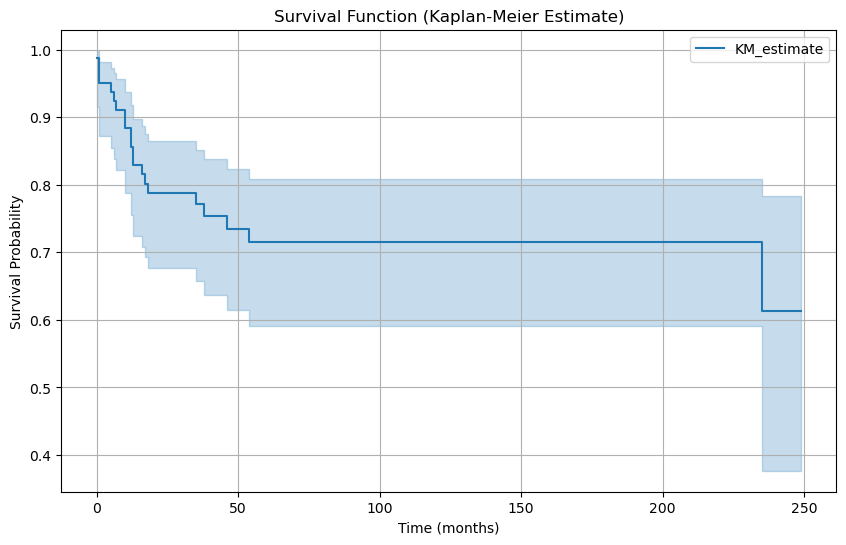

In [24]:
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Survival Function (Kaplan-Meier Estimate)')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()